<a href="https://colab.research.google.com/github/alandgmendes/dataScienceAcademyStash/blob/main/MiniProjeto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is an exploratory data analysis, part of the  course Python Fundamentos Para Análise de Dados 3.0 from  [Data Science Academy](www.datascienceacademy.com.br/start)

#### This is a free course offered by Data science academy, and I am A physics student, working with webdev and moving on to data science

## We will analyse real data from [IMDB - International movie DataBase](https://www.imdb.com)

#### 

### We will use python, sqlite and sql in order to obtain some insights about the movie data in imdb


### Our analysis will try to cover the following questions about movies:

1. Most commom categories of movies on Imbd

2. Number of titles per genre

3. Ratings median of movies by genre

4. Ratings median of movies by debut year

5. Number of rated movies by gender relatied to debut year

6. Movie with greater duration

7. Relation between duration and gender

8. Number of movies by country of production
 
9. Top 10 movies

11. "Bottom 10" movies

## Setup


In order to do this analisys, we will use some packages containing pre-made basic tools, since we don't want to spend time re-doing good tools.


First of all, let us keep tracking of the python version we are using:


In [82]:
from platform import python_version
print("Using " + python_version() + " version of python")


Using 3.7.12 version of python


Since we will analyze data about imdb movies, we will now prepare to get our data.

First of all, from pypi we will import a [package](https://pypi.org/project/imdb-sqlite/) containing a database that stores data about Imdb movies. 


In [83]:
!pip install -q imdb_sqlite

We will also import [another package](https://pypi.org/project/pycountry/) to join countries and their ISO code

In [84]:
!pip install -q pycountry

We will also use a set of packages for our ingest, processing and analysis. Since the operations will be described as we proceed, I wont bother the user with minucios description about each package right now

In [85]:

import re
import time
import sqlite3
import pycountry
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

Now we proceed to download the data. Every first execution will take a long time since it will download all the data fron the package(nearly 10gb).

I may come back to store this data remotely in a way that can be accessed in a more friendly way, or maybe store just a part of these data.

In [86]:
%%time
!imdb-sqlite

2022-02-28 21:40:42,784 DB already exists: (imdb.db). Refusing to modify. Exiting
CPU times: user 10 ms, sys: 37.2 ms, total: 47.2 ms
Wall time: 277 ms


Now we create a connection from our notebook to the database

In [87]:
conn = sqlite3.connect("imdb.db")

We will query the tables in the database

In [88]:
tables = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

And check the tables stored

In [89]:
tables.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


Now we will see what kind of data is stored in these tables, and their links

In [90]:
table_list = tables["Table_Name"].values.tolist()

for table in table_list:
    cons = "PRAGMA TABLE_INFO({})".format(table)
    result = pd.read_sql_query(cons, conn)
    print("Table " + table + "'s schema: '")
    display(result)
    print("-"*100)
    print("\n")

Table people's schema: '


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Table titles's schema: '


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Table akas's schema: '


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Table crew's schema: '


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Table episodes's schema: '


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Table ratings's schema: '


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




Since we get our data straight and checked it's shape, it's time to analyze it.

## Analysis

We will start with our first question:


### 1 - Most commom categories of movies on Imbd

We will create a query returning the titles and their type, group the titles by their type. These data will be on a table. But sometimes a table is not so ergonomic, specially in decision-taking sometimes we must use graphic output of information. Son, not only we will show a table with the titles, their total numbers and percentage, we will also plot a graphic showing the 3 categories with more titles compared to other categories

In [91]:
cons_category_count = '''SELECT type, COUNT(*)  AS COUNT FROM titles GROUP BY type'''
result_category_count = pd.read_sql_query(cons_category_count, conn)

result_category_count['percentage'] = (result_category_count['COUNT']  /result_category_count['COUNT'].sum()) * 100

display(result_category_count)

others = {}

others['COUNT'] = result_category_count[result_category_count['percentage'] < 5 ]['COUNT'].sum()

others['percentage'] = result_category_count[result_category_count['percentage'] < 5 ]['percentage'].sum()

others['type'] = "others"

others

,type,COUNT,percentage
0,movie,603298,6.909477
1,short,858052,9.827134
2,tvEpisode,6536131,74.857278
3,tvMiniSeries,42307,0.484535
4,tvMovie,135140,1.547737
5,tvPilot,2,0.000023
6,tvSeries,221737,2.539519
7,tvShort,10478,0.120003
8,tvSpecial,36076,0.413173
9,video,257743,2.951890


{'COUNT': 733976, 'percentage': 8.406111374081096, 'type': 'others'}

Since we grouped others, we will remove them from our original dataset and in its place we will put the "others" aggregated data

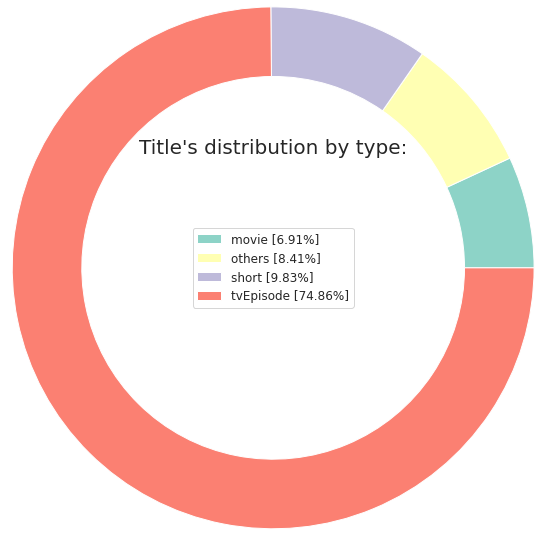

In [92]:
result_category_count = result_category_count[result_category_count['percentage'] > 5]

result_category_count = result_category_count.append(others, ignore_index=True)

result_category_count = result_category_count.sort_values(by = 'COUNT', ascending = True)

labels = [str(result_category_count['type'][i]) + ' ' + '[' + str(round(result_category_count['percentage'][i], 2)) + '%' + ']' for i in result_category_count.index]

cs = cm.Set3(np.arange(100))

f = plt.figure()

plt.pie(result_category_count['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width=0.8))

plt.legend(labels = labels, loc ='center', prop = {'size':12})

plt.title("Title's distribution by type:" ,loc='Center', fontdict={'fontsize': 20, 'fontweight': 20})

plt.show()

### 2 - Number of titles per genre

Now we will group our titles by their genre, instead of type. Before we find out what is the most common format of media in imdb, and now we will check which gender are the top present in the availations.



In order to do this, we will query the titles table, we will count the movies and group them by genre, then we will calculate the portion of each genre.

In [93]:
consult_genre_count = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

result_genre_count= pd.read_sql_query(consult_genre_count, conn)

display(result_genre_count)

result_genre_count['genres'].str.lower().values

temp = result_genre_count['genres'].dropna()

,genres,COUNT(*)
0,Action,13858
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1446,"Thriller,Western",43
1447,War,1288
1448,"War,Western",14
1449,Western,5112


Since there are titles with more than one genre, we will first split the multi-genre movies and count only the unique genres.

We will do it by first taking the column names, then we will use CountVectorize to transform it in a bag of words, and using
this bag of words, we will build a sparse matrix with one hot encoders for each genre. So we will manipulate the data way 
easier 

In [94]:
consult_genre_count = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

result_genre_count= pd.read_sql_query(consult_genre_count, conn)

result_genre_count['genres'].str.lower().values

temp = result_genre_count['genres'].dropna()

pattern = '(?u)\\b[\\w-]+\\b'

vector = CountVectorizer(token_pattern = pattern, analyzer = 'word').fit(temp)

bag_genres = vector.transform(temp)

unique_genres = vector.get_feature_names()

genres = pd.DataFrame(bag_genres.todense(), columns =unique_genres, index = temp.index)

genres.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1450
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1451 non-null   int64
 1   adult        1451 non-null   int64
 2   adventure    1451 non-null   int64
 3   animation    1451 non-null   int64
 4   biography    1451 non-null   int64
 5   comedy       1451 non-null   int64
 6   crime        1451 non-null   int64
 7   documentary  1451 non-null   int64
 8   drama        1451 non-null   int64
 9   family       1451 non-null   int64
 10  fantasy      1451 non-null   int64
 11  film-noir    1451 non-null   int64
 12  game-show    1451 non-null   int64
 13  history      1451 non-null   int64
 14  horror       1451 non-null   int64
 15  music        1451 non-null   int64
 16  musical      1451 non-null   int64
 17  mystery      1451 non-null   int64
 18  n            1451 non-null   int64
 19  news         1451 non-null   int64
 20  reality-

We have an invasor column, "n", we will eliminate it and plot an horizontal bars graphic with all genres

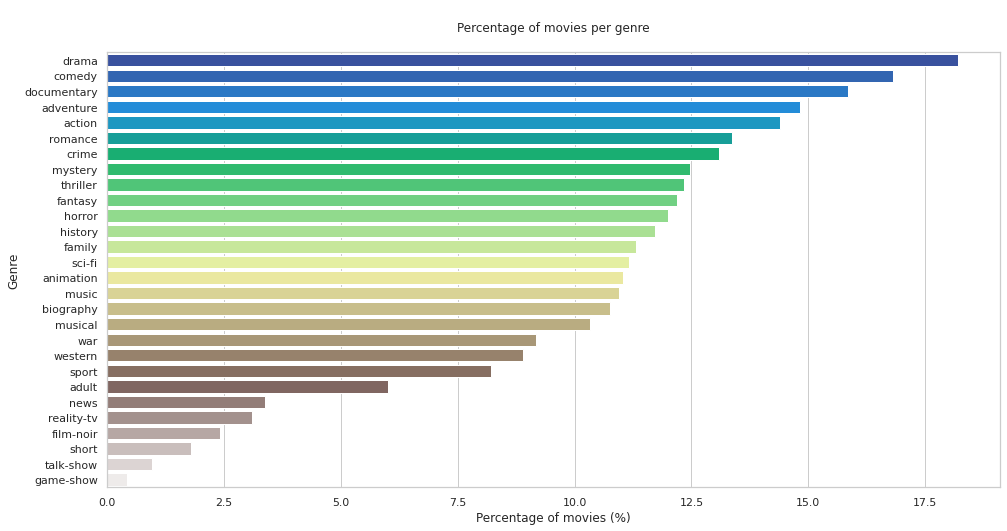

In [95]:
genres = genres.drop(columns = 'n', axis = 0)

genres_percentage = 100 * pd.Series(genres.sum()).sort_values(ascending = False) / genres.shape[0]

genres_percentage.head(30)

plt.figure(figsize = (16, 8))

sns.barplot(x = genres_percentage.values, y = genres_percentage.index, orient = "h", palette = "terrain")

plt.ylabel('Genre')

plt.xlabel('Percentage of movies (%)')

plt.title("\nPercentage of movies per genre\n")

plt.show()

This distribution suggests further observation over the different classifications, but we will do it in other occasion.

By now, we can say that drama has the highest number of availations, followed by commedy, documentary, adventure, action and the other genres.

## 3 - Median by genre

Now we will inspect the median rating by movie genre.

In [96]:
consult_median_by_genre = '''
SELECT rating, genres FROM ratings JOIN titles ON ratings.title_id = titles.title_id
WHERE premiered <= 2022 AND type = 'movie'
'''

In [97]:
result_median_by_genre = pd.read_sql_query(consult_median_by_genre, conn)

In [98]:
display(result_median_by_genre)

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,4.6,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
275341,5.8,Thriller
275342,6.4,"Drama,History"
275343,3.8,"Adventure,History,War"
275344,8.3,Drama


In [99]:
def genre_get(df):
	df['genres'] = df['genres'].str.lower().values
	temp = df['genres'].dropna()
	tokenVector = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
	unique_genres = tokenVector.get_feature_names()
	unique_genres = [genre for genre in unique_genres if len(genre) > 1]
	return unique_genres
 

In [100]:
unique_genres = genre_get(result_median_by_genre)

Unique genres splitted:

In [101]:
unique_genres

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [102]:
genre_counts = []
genre_ratings = []

In [103]:
for item in genres:
	consult = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE ' + '\'' + '%' + item + '%'  + '\' AND type = \'movie\''
	result = pd.read_sql_query(consult, conn)
	genre_counts.append(result.values[0][0])

	consult = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id = titles.title_id WHERE genres LIKE ' + '\'' + '%' + item + '%'  + '\' AND type = \'movie\''
	result = pd.read_sql_query(consult, conn)
	genre_ratings.append(np.median(result['rating']))

In [104]:
df_genre_ratings = pd.DataFrame()
df_genre_ratings['genres'] = unique_genres
df_genre_ratings['count'] = genre_counts
df_genre_ratings['rating'] = genre_ratings


In [105]:
df_genre_ratings.head(20)

,genres,count,rating
0,action,28539,5.8
1,adult,4309,5.9
2,adventure,17303,6.0
3,animation,4736,6.6
4,biography,8309,7.0
5,comedy,68201,6.0
6,crime,23511,6.1
7,documentary,40875,7.3
8,drama,121963,6.3
9,family,10648,6.3


In [106]:
df_genre_ratings = df_genre_ratings.drop(index=18)

In [107]:
df_genre_ratings = df_genre_ratings.sort_values(by = 'rating', ascending = False)

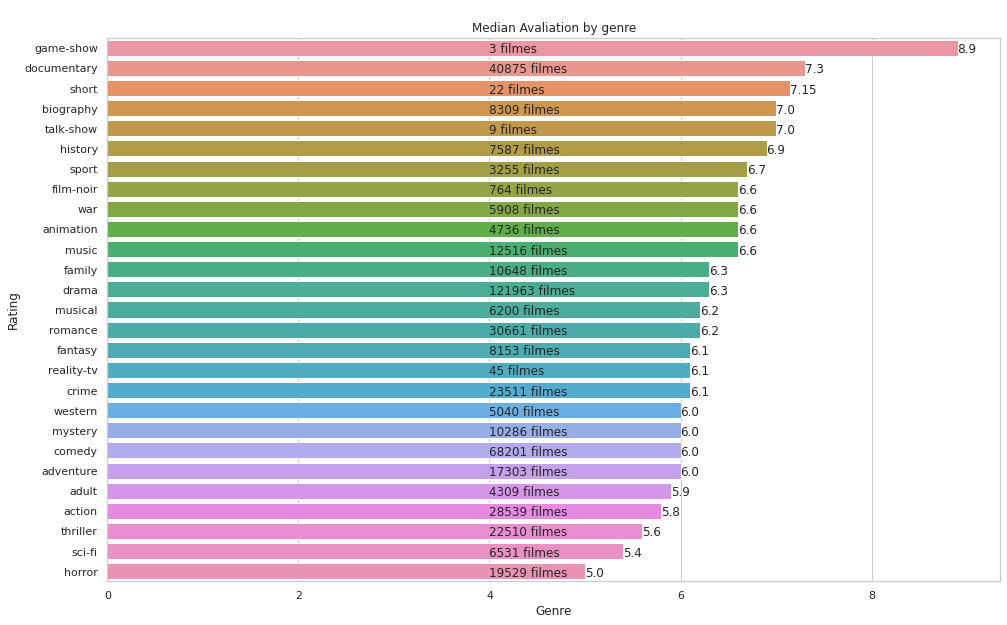

In [108]:
plt.figure(figsize = (16, 10))
sns.barplot(y = df_genre_ratings.genres, x = df_genre_ratings.rating, orient="h")
for i in range(len(df_genre_ratings.index)):
	plt.text(4.0, i + 0.25,
	str(df_genre_ratings['count'][df_genre_ratings.index[i]]) + " filmes")
	plt.text(df_genre_ratings.rating[df_genre_ratings.index[i]], i + 0.25,
	round(df_genre_ratings['rating'][df_genre_ratings.index[i]], 2))
    
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.title('\nMedian Avaliation by genre')
plt.show()


## 4 - Median Rating by year


In [109]:
consult4 = '''
SELECT rating AS Rating, premiered FROM ratings JOIN titles ON ratings.title_id = titles.title_id
WHERE premiered <= 2022 AND type = 'movie'
ORDER BY premiered
'''

In [110]:
result4 = pd.read_sql_query(consult4, conn)

In [111]:
display(result4)

,Rating,premiered
0,6.2,1896
1,4.5,1897
2,4.0,1899
3,3.7,1899
4,6.0,1900
...,...,...
275341,3.9,2022
275342,9.1,2022
275343,4.2,2022
275344,6.1,2022


In [112]:
# Calculating median along time

ratings = []
for year in set(result4 ['premiered']):
	ratings.append(np.median(result4[result4['premiered'] == year]['Rating']))

In [113]:
ratings[1:10]

[4.5, 3.85, 5.85, 6.3, 3.5, 4.6, 5.4, 4.5, 3.6]

In [114]:
anos = list(set(result4['premiered']))

In [115]:
anos[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

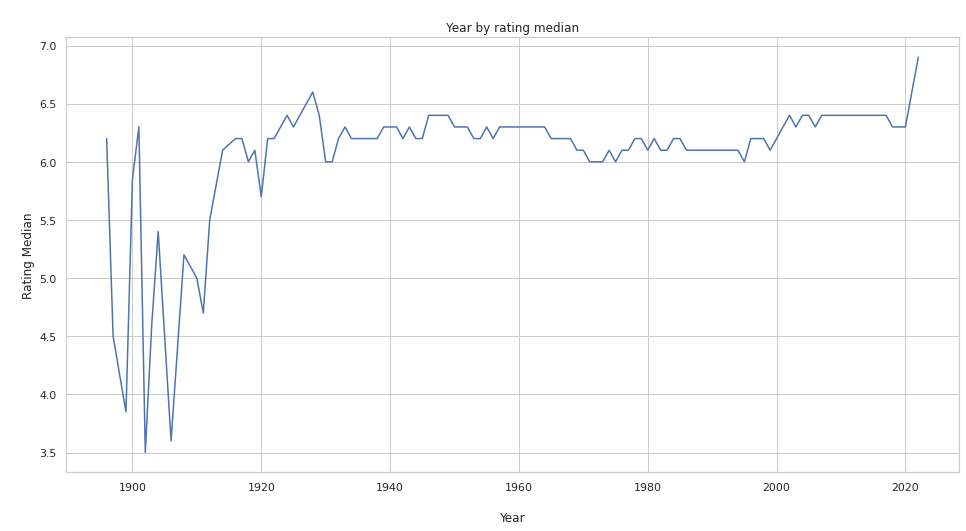

In [116]:
plt.figure(figsize = (16, 8))
plt.plot(anos, ratings)
plt.xlabel('\nYear')
plt.ylabel('\nRating Median')
plt.title('\nYear by rating median')
plt.show()

## 5 - # of Rated movies by genre related to starring year

Now we will plot a graphic showing the number of ratings by year, in the top 5 rated genres.


In [117]:
#sql consult: 

In [118]:
consult5 = '''SELECT genres FROM titles'''

In [119]:
result5 = pd.read_sql_query(consult5, conn)

In [120]:
display(result5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8731452,"Action,Drama,Family"
8731453,"Action,Drama,Family"
8731454,"Action,Drama,Family"
8731455,Short


In [121]:
unique_genres = genre_get(result5)

In [122]:
display(unique_genres)

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [127]:
genre_count = []
for item in unique_genres:
	consult = 'SELECT COUNT(*) COUNT FROM titles WHERE genres LIKE ' + '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
	result = pd.read_sql_query(consult, conn)
	genre_count.append(result['COUNT'].values[0])

In [128]:

#preparing dataframe
df_genre_count = pd.DataFrame()
df_genre_count['genre'] = unique_genres
df_genre_count['Count'] = genre_count

In [129]:
#getting top 5 

df_genre_count = df_genre_count[df_genre_count['genre'] != 'n']
df_genre_count = df_genre_count.sort_values(by = 'Count', ascending = False)
top_genres = df_genre_count.head()['genre'].values


array(['drama', 'documentary', 'comedy', 'action', 'romance'],
      dtype=object)

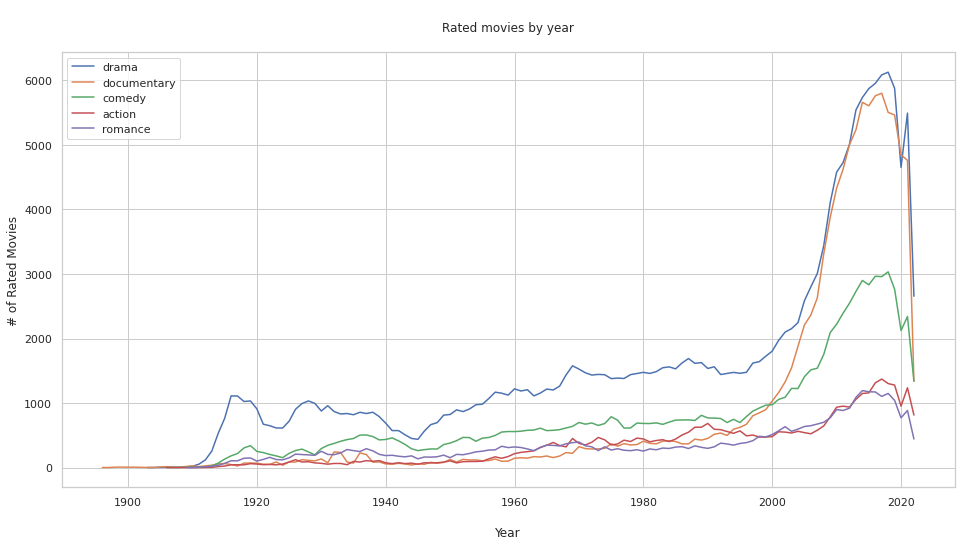

In [131]:
# Plot

# Figura
plt.figure(figsize = (16,8))

# Loop e Plot
for item in top_genres:
    consult = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    result = pd.read_sql_query(consult, conn)
    plt.plot(result['Year'], result['Number_of_movies'])

plt.xlabel('\nYear')
plt.ylabel('# of Rated Movies')
plt.title('\nRated movies by year\n')
plt.legend(labels = top_genres)
plt.show()

# 6 - Longest Movies

Now we will show the longest films, and their duration in percentiles